In [1]:
import wandb
import pandas as pd
import seaborn as sns
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
api = wandb.Api()

In [2]:
entity, project = "real-lab", "simple-icl"
runs = api.runs(entity + "/" + project)
SAVE_DIR = "plots"

In [3]:
BASELINES = {"feasible_reward":
                {"half_cheetah": {"GACL":3.48e3*2, "BC2L": 8.70e2*2, "MECL": 3.02e3*2, "VICRL": 3.81e3*2},
                 "ant": {"GACL":7.21e3, "BC2L": 1.20e4, "MECL": 8.55e3, "VICRL": 1.37e4},
                 "inverted_pendulum": {"GACL":8.50e-1, "BC2L": 5.73e0, "MECL": 1.02e0, "VICRL": 6.64e0},
                 "walker2d": {"GACL":2.84e1, "BC2L": 4.87e1, "MECL": 1.27e2, "VICRL": 9.34e1},
                 "swimmer": {"GACL":5.78e2, "BC2L": 1.41e2, "MECL": 6.37e1, "VICRL": 1.91e2}
                },
             "violation_rate":
                {"half_cheetah": {"GACL":0, "BC2L": 0.47, "MECL": 0.4, "VICRL": 0},
                 "ant": {"GACL":0, "BC2L": 0, "MECL": 0, "VICRL": .02},
                 "inverted_pendulum": {"GACL":1, "BC2L": 0.58, "MECL": 0.73, "VICRL": 0.39},
                 "walker2d": {"GACL":0, "BC2L": 0, "MECL": 0.19, "VICRL": 0.07},
                 "swimmer": {"GACL":0.42, "BC2L": 0.84, "MECL": 0.88, "VICRL": 0.59}
                }
}
ENVS = ["walker2d", "inverted_pendulum", "swimmer", "half_cheetah", "ant"]
NAMES_DICT = {'irl': "IRL",
              'irl + policy reset': "PR",
              "base": "SC",
              "base + policy reset": "SC+PR",
              "base + policy reset + bn": "SC+PR+BN",
              "base + policy reset + reward norm": "SC+PR+RN",
              "base + policy reset + bn +reward norm": "SC+PR+BN+RN",
              "sub optsub_opt0.2": "20%",
              "sub optsub_opt0.5": "50%",
              "sub optsub_opt0.8": "80%",
              "best_baseline": "ICRL"}

In [4]:
def get_data(runs, metrics=["test/feasible_reward", "test/violation_rate"], add_from_config=["seed"]):
    df = pd.DataFrame()
    for run in runs:
        temp_df = run.history(keys=metrics, x_axis='_step', samples=1000)
        temp_df['config'] = ''.join(run.tags)
        for x in add_from_config:
            cons = x.split(".")
            temp = run.config[cons[0]]
            for con in cons[1:]:
                temp = temp[con]
            temp_df[x] = temp
        df = pd.concat([df, temp_df])
    df = df.reset_index(drop=True)
    df.columns = df.columns.str.split('/').str[-1]
    return df

In [5]:
def make_plot(df, ax, env="walker2d", baselines=True, exps=None, group_nsteps=20000, 
              metric='feasible_reward', include_legend=False, hue_order=None, font_scale=1.7): 
    df = df[df.env==env]
    df.loc[:,'config'] = df.config.replace(NAMES_DICT)
    if exps is not None:
        df = df[df.config.isin(exps)]

    # add baselines
    if isinstance(baselines, dict):
        baselines_df = pd.DataFrame()

        for key, val in baselines["MECL"].items():
            temp_df = pd.DataFrame({"env_step": range(0, int(df._step.max()), 5000)})
            temp_df["env_step"] = temp_df["env_step"]+1
            temp_df['config'] = f"MECL {key}"
            temp_df[metric] = val
            baselines_df = pd.concat([temp_df, baselines_df])
        for key, val in baselines["GACL"].items():
            temp_df = pd.DataFrame({"env_step": range(0, int(df._step.max()), 5000)})
            temp_df["env_step"] = temp_df["env_step"]+1
            temp_df['config'] = f"GACL {key}"
            temp_df[metric] = val
            baselines_df = pd.concat([temp_df, baselines_df])

    sns.set(font_scale=font_scale)
    # df.loc[:, "env_step"] = pd.cut(df._step, np.arange(0, df._step.max() + group_nsteps, group_nsteps)).apply(lambda x: x.left).astype(int)
    df = df.loc[df._step >= group_nsteps,:]
    df.loc[:, "env_step"] = df._step.apply(lambda x: [x for x in range(int(x//5000*5000), min(int(x//5000*5000)+group_nsteps, 5000000), 5000)])
    df = df.explode('env_step').reset_index(drop=True)

    sns.lineplot(data=df, x='env_step', y=metric, hue='config', ax=ax, palette="Dark2", errorbar="sd", lw=2,#palette="CMRmap", errorbar="sd", lw=2,
                hue_order=hue_order)
    if isinstance(baselines, dict):
        sns.lineplot(data=baselines_df[baselines_df.config.str.contains("MECL")], x='env_step', y=metric, hue='config', ax=ax, palette="Dark2", errorbar="sd", lw=3,
                hue_order=hue_order, ls='dashed')
        sns.lineplot(data=baselines_df[baselines_df.config.str.contains("GACL")], x='env_step', y=metric, hue='config', ax=ax, palette="Dark2", errorbar="sd", lw=3,
            hue_order=hue_order,ls='dashdot')
    elif baselines:
        # sns.lineplot(data=baselines_df, x='env_step', y=metric, hue="config", ax=ax, lw=2)
        ax.axhline(BASELINES[metric][env]['MECL'], ls='--', label='MECL', linewidth = 3)
        ax.axhline(BASELINES[metric][env]['GACL'], ls='--', c='g', label="GACL",linewidth = 3)

    if include_legend:
        sns.move_legend(ax, loc="lower center", bbox_to_anchor=(-0.2, 1.05), ncol=3, title=None, frameon=False)
    else:
        ax.get_legend().remove()
    title = ' '.join([x.capitalize() for x in metric.split('_')])
    ax.set_title(title, fontsize=20)
    ax.set(xlabel=None, ylabel=None)
    return 

In [13]:
group_nsteps=200000
df = df.loc[df._step >= group_nsteps,:]
df.loc[:, "env_step"] = df._step.apply(lambda x: [x for x in range(int(x//5000*5000), min(int(x//5000*5000)+group_nsteps, 5000000), 5000)])
df = df.explode('env_step').reset_index(drop=True)

: 

In [12]:
df.head()

,_step,feasible_reward,violation_rate,config,seed,env,env_step
0,200128.0,985.97529,0.0,irl,2,walker2d,200000
1,200128.0,985.97529,0.0,irl,2,walker2d,205000
2,200128.0,985.97529,0.0,irl,2,walker2d,210000
3,200128.0,985.97529,0.0,irl,2,walker2d,215000
4,200128.0,985.97529,0.0,irl,2,walker2d,220000


### Primary Experiments

In [6]:
experiment_names = ['irl', 'irl + policy reset', 'base', 'base + policy reset', 'base + policy reset + bn', 
                    "base + policy reset + reward norm", "base + policy reset + bn +reward norm", "best_baseline"]
experiments = [api.runs(entity + "/" + project, filters={'tags': exp}) for exp in experiment_names]
runs = [run for runs in experiments for run in runs ]
runs = [(run, '_'.join(re.sub(r"([A-Z])", r"_\1", run.config["task"].split('-')[0]).split('_')[1:-1]).lower()) for run in runs]
runs_by_env = {env: [run[0] for run in runs if run[1]==env] for env in ENVS}

In [7]:
def unnest(d, keys=[]):
    result = []
    for k, v in d.items():
        if isinstance(v, dict):
            result.extend(unnest(v, keys + [k]))
        else:
            result.append(keys + [k,v])
    return result

In [8]:
config_dict = unnest(runs[0][0].config)
config_dict = {tuple(x[:-1]): x[-1] for x in config_dict}

In [9]:
config_dict

{('data', '_target_'): 'src.data.readers.ICRLReader',
 ('seed',): 1,
 ('task',): 'SwimmerWall-v0',
 ('device',): 'cuda',
 ('logger', 'name'): 'SwimmerWall-v0-1',
 ('logger', 'project'): 'simple-icl',
 ('logger', '_target_'): 'fsrl.utils.logger.WandbLogger',
 ('policy', 'tau'): 0.005,
 ('policy', 'actor', '_target_'): 'src.utils.net.continuous.ActorProb',
 ('policy', 'actor', 'unbounded'): True,
 ('policy',
  'actor',
  'preprocess_net',
  '_target_'): 'tianshou.utils.net.common.Net',
 ('policy', 'actor', 'preprocess_net', 'hidden_sizes'): [256, 256],
 ('policy', 'actor', 'conditioned_sigma'): True,
 ('policy', 'alpha', 'optim', 'lr'): 0.0003,
 ('policy', 'alpha', 'optim', '_target_'): 'torch.optim.Adam',
 ('policy', 'gamma'): 0.99,
 ('policy', 'critic', '_target_'): 'src.utils.net.continuous.Critic',
 ('policy', 'critic', 'preprocess_net', 'concat'): True,
 ('policy',
  'critic',
  'preprocess_net',
  '_target_'): 'tianshou.utils.net.common.Net',
 ('policy', 'critic', 'preprocess_net',

In [10]:
config_df = pd.DataFrame.from_dict(config_dict, orient="index")

In [11]:
print(config_df[config_df.index.str[0]=="policy"].to_latex())

\begin{tabular}{ll}
\toprule
 & 0 \\
\midrule
('policy', 'tau') & 0.005000 \\
('policy', 'actor', '_target_') & src.utils.net.continuous.ActorProb \\
('policy', 'actor', 'unbounded') & True \\
('policy', 'actor', 'preprocess_net', '_target_') & tianshou.utils.net.common.Net \\
('policy', 'actor', 'preprocess_net', 'hidden_sizes') & [256, 256] \\
('policy', 'actor', 'conditioned_sigma') & True \\
('policy', 'alpha', 'optim', 'lr') & 0.000300 \\
('policy', 'alpha', 'optim', '_target_') & torch.optim.Adam \\
('policy', 'gamma') & 0.990000 \\
('policy', 'critic', '_target_') & src.utils.net.continuous.Critic \\
('policy', 'critic', 'preprocess_net', 'concat') & True \\
('policy', 'critic', 'preprocess_net', '_target_') & tianshou.utils.net.common.Net \\
('policy', 'critic', 'preprocess_net', 'hidden_sizes') & [256, 256] \\
('policy', '_target_') & src.policies.IRLSACPolicy \\
('policy', 'lagrangian') & 1 \\
('policy', 'actor_optim', 'lr') & 0.001000 \\
('policy', 'actor_optim', '_target_')

In [12]:
print(config_df[config_df.index.str[0]=="reward"].to_latex())

\begin{tabular}{ll}
\toprule
 & 0 \\
\midrule
('reward', 'net', '_target_') & src.utils.net.continuous.Reward \\
('reward', 'net', 'clip_range') & [-20, 0] \\
('reward', 'net', 'preprocess_net', 'concat') & True \\
('reward', 'net', 'preprocess_net', '_target_') & tianshou.utils.net.common.Net \\
('reward', 'net', 'preprocess_net', 'norm_layer') & NaN \\
('reward', 'net', 'preprocess_net', 'hidden_sizes') & [64, 64] \\
('reward', 'optim', 'lr') & 0.000100 \\
('reward', 'optim', '_target_') & torch.optim.Adam \\
('reward', 'optim', 'weight_decay') & 0.001000 \\
('reward', '_target_') & src.rewards.reward_learner.RewardLearner \\
('reward', 'batch_size') & 5000 \\
('reward', 'lr_scheduler') & NaN \\
('reward', 'is_constraint') & False \\
('reward', 'steps_per_epoch') & 1 \\
('reward', 'learn_true_rewards') & False \\
('reward', 'regularization_coeff') & 0 \\
\bottomrule
\end{tabular}



In [13]:
print(config_df[config_df.index.str[0]=="trainer"].to_latex())

\begin{tabular}{ll}
\toprule
 & 0 \\
\midrule
('trainer', '_target_') & src.trainer.OffpolicyTrainer \\
('trainer', 'max_epoch') & 1000 \\
('trainer', 'batch_size') & 128 \\
('trainer', 'step_per_epoch') & 5000 \\
('trainer', 'update_per_step') & 1 \\
('trainer', 'episode_per_test') & 5 \\
('trainer', 'episode_per_collect') & 1 \\
\bottomrule
\end{tabular}



In [14]:
pd.DataFrame.from_records(runs[0][0].config)

,collector,cost_fn,data,device,expert_data_path,log_path,logger,normalize_obs,normalize_reward,policy,reset_policy,reward,seed,task,test_buffer_size,test_env_num,train_buffer_size,train_env_num,trainer,warmstart_episodes
_target_,src.data.collector.Collector,src.utils.cost_functions.wall_infront,src.data.readers.ICRLReader,cuda,/scratch/data/multi-irl/icrl/swimmer,wandb/2024-05-15_20-06-51,fsrl.utils.logger.WandbLogger,False,False,src.policies.IRLSACPolicy,False,src.rewards.reward_learner.RewardLearner,1,SwimmerWall-v0,10000,5,1000000,1,src.trainer.OffpolicyTrainer,1
pos,NaN,0.5,NaN,cuda,/scratch/data/multi-irl/icrl/swimmer,wandb/2024-05-15_20-06-51,NaN,False,False,NaN,False,NaN,1,SwimmerWall-v0,10000,5,1000000,1,NaN,1
name,NaN,NaN,NaN,cuda,/scratch/data/multi-irl/icrl/swimmer,wandb/2024-05-15_20-06-51,SwimmerWall-v0-1,False,False,NaN,False,NaN,1,SwimmerWall-v0,10000,5,1000000,1,NaN,1
project,NaN,NaN,NaN,cuda,/scratch/data/multi-irl/icrl/swimmer,wandb/2024-05-15_20-06-51,simple-icl,False,False,NaN,False,NaN,1,SwimmerWall-v0,10000,5,1000000,1,NaN,1
tau,NaN,NaN,NaN,cuda,/scratch/data/multi-irl/icrl/swimmer,wandb/2024-05-15_20-06-51,NaN,False,False,0.005,False,NaN,1,SwimmerWall-v0,10000,5,1000000,1,NaN,1
actor,NaN,NaN,NaN,cuda,/scratch/data/multi-irl/icrl/swimmer,wandb/2024-05-15_20-06-51,NaN,False,False,{'_target_': 'src.utils.net.continuous.ActorPr...,False,NaN,1,SwimmerWall-v0,10000,5,1000000,1,NaN,1
alpha,NaN,NaN,NaN,cuda,/scratch/data/multi-irl/icrl/swimmer,wandb/2024-05-15_20-06-51,NaN,False,False,"{'optim': {'lr': 0.0003, '_target_': 'torch.op...",False,NaN,1,SwimmerWall-v0,10000,5,1000000,1,NaN,1
gamma,NaN,NaN,NaN,cuda,/scratch/data/multi-irl/icrl/swimmer,wandb/2024-05-15_20-06-51,NaN,False,False,0.99,False,NaN,1,SwimmerWall-v0,10000,5,1000000,1,NaN,1
critic,NaN,NaN,NaN,cuda,/scratch/data/multi-irl/icrl/swimmer,wandb/2024-05-15_20-06-51,NaN,False,False,{'_target_': 'src.utils.net.continuous.Critic'...,False,NaN,1,SwimmerWall-v0,10000,5,1000000,1,NaN,1
lagrangian,NaN,NaN,NaN,cuda,/scratch/data/multi-irl/icrl/swimmer,wandb/2024-05-15_20-06-51,NaN,False,False,1,False,NaN,1,SwimmerWall-v0,10000,5,1000000,1,NaN,1


In [15]:
walker_df = get_data(runs_by_env['walker2d'])
walker_df['env'] = 'walker2d'
swimmer_df = get_data(runs_by_env['swimmer'])
swimmer_df['env'] = 'swimmer'
cheetah_df = get_data(runs_by_env['half_cheetah'])
cheetah_df['env'] = 'half_cheetah'
pendulum_df = get_data(runs_by_env['inverted_pendulum'])
pendulum_df['env'] = 'inverted_pendulum'
ant_df = get_data(runs_by_env['ant'])
ant_df['env'] = 'ant'
all_df = pd.concat([walker_df, swimmer_df, cheetah_df, pendulum_df, ant_df])

In [16]:
all_df = pd.concat([walker_df, swimmer_df, cheetah_df, pendulum_df, ant_df])

In [17]:
df = all_df

In [18]:
results = {'feasible_rewards': {env:{} for env in ENVS},
           'violation_rate':{env: {} for env in ENVS}}

In [19]:
results['feasible_rewards']['half_cheetah'].update(cheetah_df[cheetah_df._step > 4900000].groupby("config")['feasible_reward'].mean().to_dict())
results['feasible_rewards']['ant'].update(ant_df[ant_df._step > 4900000].groupby("config")['feasible_reward'].mean().to_dict())
results['feasible_rewards']['walker2d'].update(walker_df[walker_df._step > 4900000].groupby("config")['feasible_reward'].mean().to_dict())
results['feasible_rewards']['inverted_pendulum'].update(pendulum_df[pendulum_df._step > 4900000].groupby("config")['feasible_reward'].mean().to_dict())
results['feasible_rewards']['swimmer'].update(swimmer_df[swimmer_df._step > 4900000].groupby("config")['feasible_reward'].mean().to_dict())

results['violation_rate']['half_cheetah'].update(cheetah_df[cheetah_df._step > 4900000].groupby("config")['violation_rate'].mean().to_dict())
results['violation_rate']['ant'].update(ant_df[ant_df._step > 4900000].groupby("config")['violation_rate'].mean().to_dict())
results['violation_rate']['walker2d'].update(walker_df[walker_df._step > 4900000].groupby("config")['violation_rate'].mean().to_dict())
results['violation_rate']['inverted_pendulum'].update(pendulum_df[pendulum_df._step > 4900000].groupby("config")['violation_rate'].mean().to_dict())
results['violation_rate']['swimmer'].update(swimmer_df[swimmer_df._step > 4900000].groupby("config")['violation_rate'].mean().to_dict())

In [20]:
results['feasible_rewards']['half_cheetah'].update(cheetah_df[(cheetah_df._step > 4900000) | ((cheetah_df.config=="best_baseline") & (cheetah_df._step > (cheetah_df[cheetah_df.config=="best_baseline"]._step.max()-100000)))].groupby("config")['feasible_reward'].mean().to_dict())
results['feasible_rewards']['ant'].update(ant_df[(ant_df._step > 4900000) | ((ant_df.config=="best_baseline") & (ant_df._step > (ant_df[ant_df.config=="best_baseline"]._step.max()-100000)))].groupby("config")['feasible_reward'].mean().to_dict())
results['feasible_rewards']['walker2d'].update(walker_df[(walker_df._step > 4900000) | ((walker_df.config=="best_baseline") & (walker_df._step > (walker_df[walker_df.config=="best_baseline"]._step.max()-100000)))].groupby("config")['feasible_reward'].mean().to_dict())
results['feasible_rewards']['inverted_pendulum'].update(pendulum_df[(pendulum_df._step > 4900000) | ((pendulum_df.config=="best_baseline") & (pendulum_df._step > (pendulum_df[pendulum_df.config=="best_baseline"]._step.max()-100000)))].groupby("config")['feasible_reward'].mean().to_dict())
results['feasible_rewards']['swimmer'].update(swimmer_df[(swimmer_df._step > 4900000) | ((swimmer_df.config=="best_baseline") & (swimmer_df._step > (swimmer_df[swimmer_df.config=="best_baseline"]._step.max()-100000)))].groupby("config")['feasible_reward'].mean().to_dict())

results['violation_rate']['half_cheetah'].update(cheetah_df[(cheetah_df._step > 4900000) | ((cheetah_df.config=="best_baseline") & (cheetah_df._step > (cheetah_df[cheetah_df.config=="best_baseline"]._step.max()-100000)))].groupby("config")['violation_rate'].mean().to_dict())
results['violation_rate']['ant'].update(ant_df[(ant_df._step > 4900000) | ((ant_df.config=="best_baseline") & (ant_df._step > (ant_df[ant_df.config=="best_baseline"]._step.max()-100000)))].groupby("config")['violation_rate'].mean().to_dict())
results['violation_rate']['walker2d'].update(walker_df[(walker_df._step > 4900000) | ((walker_df.config=="best_baseline") & (walker_df._step > (walker_df[walker_df.config=="best_baseline"]._step.max()-100000)))].groupby("config")['violation_rate'].mean().to_dict())
results['violation_rate']['inverted_pendulum'].update(pendulum_df[(pendulum_df._step > 4900000) | ((pendulum_df.config=="best_baseline") & (pendulum_df._step > (pendulum_df[pendulum_df.config=="best_baseline"]._step.max()-100000)))].groupby("config")['violation_rate'].mean().to_dict())
results['violation_rate']['swimmer'].update(swimmer_df[(swimmer_df._step > 4900000) | ((swimmer_df.config=="best_baseline") & (swimmer_df._step > (swimmer_df[swimmer_df.config=="best_baseline"]._step.max()-100000)))].groupby("config")['violation_rate'].mean().to_dict())

In [21]:
results["feasible_rewards"]["half_cheetah"]

{'base': 6272.958851945378,
 'base + policy reset': 9158.386721074578,
 'base + policy reset + bn': 158.8753913341664,
 'base + policy reset + bn +reward norm': 64.76591763814173,
 'base + policy reset + reward norm': 9767.715702190715,
 'irl': 7172.89375218483,
 'irl + policy reset': 1163.210244947191,
 'best_baseline': -496.1039966097407}

In [22]:
results["violation_rate"]["ant"]

{'base': 0.011920529801324504,
 'base + policy reset': 0.03493975903614458,
 'base + policy reset + bn': 0.17714285714285716,
 'base + policy reset + bn +reward norm': 0.12463768115942028,
 'base + policy reset + reward norm': 0.06290322580645162,
 'irl': 0.022222222222222223,
 'irl + policy reset': 0.01578947368421053,
 'best_baseline': 0.0}

In [23]:
fr_results_df = pd.DataFrame(results['feasible_rewards'])

In [24]:
fr_results_df = fr_results_df.loc[:, ENVS]

In [25]:
fr_results_df

,walker2d,inverted_pendulum,swimmer,half_cheetah,ant
base,472.797863,2.389776,494.188015,6272.958852,9077.170559
base + policy reset,361.606213,8.341082,362.809032,9158.386721,7134.190332
base + policy reset + bn,931.898988,0.971023,73.617127,158.875391,2446.554338
base + policy reset + bn +reward norm,389.245462,0.306994,83.019353,64.765918,502.430595
base + policy reset + reward norm,319.132485,4.781469,447.075268,9767.715702,646.945546
irl,82.903091,7.825299,605.280463,7172.893752,4400.333665
irl + policy reset,208.931946,4.351329,353.065296,1163.210245,1153.196437
best_baseline,443.460368,2.502120,50.508253,-496.103997,580.035004


In [26]:
fr_results_df.loc["MECL", :] = [BASELINES['feasible_reward'][env]['MECL'] for env in ENVS]
fr_results_df.loc["GACL", :] = [BASELINES['feasible_reward'][env]['GACL'] for env in ENVS]

In [27]:
fr_results_df

,walker2d,inverted_pendulum,swimmer,half_cheetah,ant
base,472.797863,2.389776,494.188015,6272.958852,9077.170559
base + policy reset,361.606213,8.341082,362.809032,9158.386721,7134.190332
base + policy reset + bn,931.898988,0.971023,73.617127,158.875391,2446.554338
base + policy reset + bn +reward norm,389.245462,0.306994,83.019353,64.765918,502.430595
base + policy reset + reward norm,319.132485,4.781469,447.075268,9767.715702,646.945546
irl,82.903091,7.825299,605.280463,7172.893752,4400.333665
irl + policy reset,208.931946,4.351329,353.065296,1163.210245,1153.196437
best_baseline,443.460368,2.502120,50.508253,-496.103997,580.035004
MECL,127.000000,1.020000,63.700000,6040.000000,8550.000000
GACL,28.400000,0.850000,578.000000,6960.000000,7210.000000


In [28]:
vr_results_df = pd.DataFrame(results['violation_rate'])
vr_results_df = vr_results_df.loc[:, ENVS]
vr_results_df.loc["MECL", :] = [BASELINES['violation_rate'][env]['MECL'] for env in ENVS]
vr_results_df.loc["GACL", :] = [BASELINES['violation_rate'][env]['GACL'] for env in ENVS]

In [29]:
vr_results_df

,walker2d,inverted_pendulum,swimmer,half_cheetah,ant
base,0.004317,0.979104,0.390000,0.006667,0.011921
base + policy reset,0.009174,0.990244,0.586667,0.000000,0.034940
base + policy reset + bn,0.157219,0.677500,0.936667,0.846667,0.177143
base + policy reset + bn +reward norm,0.000000,0.656250,0.666667,0.790000,0.124638
base + policy reset + reward norm,0.042748,0.707895,0.430000,0.000000,0.062903
irl,0.012162,0.916923,0.216667,0.000000,0.022222
irl + policy reset,0.007500,1.000000,0.300000,0.230000,0.015789
best_baseline,0.016949,0.867857,0.433333,0.000000,0.000000
MECL,0.190000,0.730000,0.880000,0.400000,0.000000
GACL,0.000000,1.000000,0.420000,0.000000,0.000000


In [30]:
vr_results_df < vr_results_df.loc["irl", :]+0.1

,walker2d,inverted_pendulum,swimmer,half_cheetah,ant
base,True,True,False,True,True
base + policy reset,True,True,False,True,True
base + policy reset + bn,False,True,False,False,False
base + policy reset + bn +reward norm,True,True,False,False,False
base + policy reset + reward norm,True,True,False,True,True
irl,True,True,True,True,True
irl + policy reset,True,True,True,False,True
best_baseline,True,True,False,True,True
MECL,False,True,False,False,True
GACL,True,True,False,True,True


In [31]:
vr_results_df = vr_results_df.loc[["GACL", "MECL", #"best_baseline", 'irl', 'irl + policy reset', 'base', 'base + policy reset',
                               'irl', 'irl + policy reset', 'base', 'base + policy reset',
                               'base + policy reset + bn', 'base + policy reset + reward norm',
                               'base + policy reset + bn +reward norm'], :]

In [32]:
fr_results_df = fr_results_df.loc[["GACL", "MECL", #"best_baseline", 'irl', 'irl + policy reset', 'base', 'base + policy reset',
                                'irl', 'irl + policy reset', 'base', 'base + policy reset',
                               'base + policy reset + bn', 'base + policy reset + reward norm',
                               'base + policy reset + bn +reward norm'], :]

In [33]:
star_df = pd.DataFrame(columns=vr_results_df.columns, index=vr_results_df.index)
star_df[:] = '*'
star_df[vr_results_df < vr_results_df.loc["irl", :]+0.1] = ' '
star_df.index = pd.Series(star_df.index).replace(NAMES_DICT)

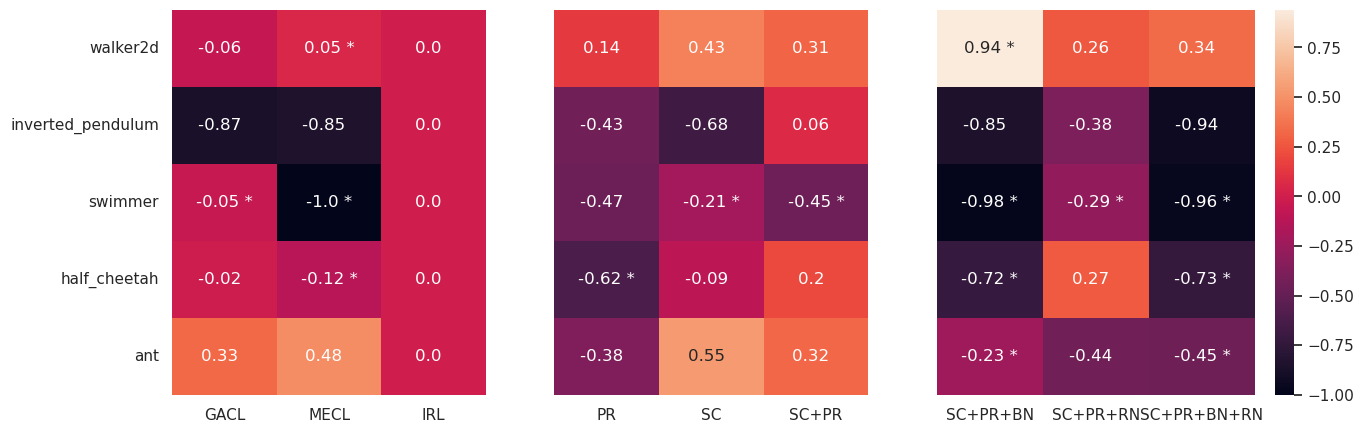

In [35]:

fig, axes = plt.subplots(1, 3, width_ratios=[3, 3, 3.8], figsize=(15,5))
scaled_df = (fr_results_df - fr_results_df.loc["irl", :])/(fr_results_df.max(axis=0) - fr_results_df.min(axis=0))
scaled_df.index = pd.Series(scaled_df.index).replace(NAMES_DICT)
sns.set(font_scale=1)
vmin = scaled_df.min().min()
vmax = scaled_df.max().max()
annot = scaled_df.round(2).astype(str) + ' ' + star_df
sns.heatmap(scaled_df.loc[["GACL", "MECL", "IRL"],:].transpose(), annot=annot.iloc[0:3,:].transpose(), fmt="", robust=True, ax=axes[0], cbar=False, vmin=vmin, vmax=vmax)
sns.heatmap(scaled_df.iloc[3:6,:].transpose(), annot=annot.iloc[3:6,:].transpose(), fmt="",  robust=True, ax=axes[1], cbar=False, vmin=vmin, vmax=vmax)
axes[1].set_yticks([])
sns.heatmap(scaled_df.iloc[6:,:].transpose(), annot=annot.iloc[6:,:].transpose(), fmt="", robust=True, ax=axes[2], vmin=vmin, vmax=vmax)
axes[2].set_yticks([])
plt.savefig(f"{SAVE_DIR}/heatmap.pdf", bbox_inches='tight')

In [36]:
exps =["IRL", "PR", "SC", "SC+PR", "SC+PR+BN", "SC+PR+RN", "SC+PR+BN+RN"]

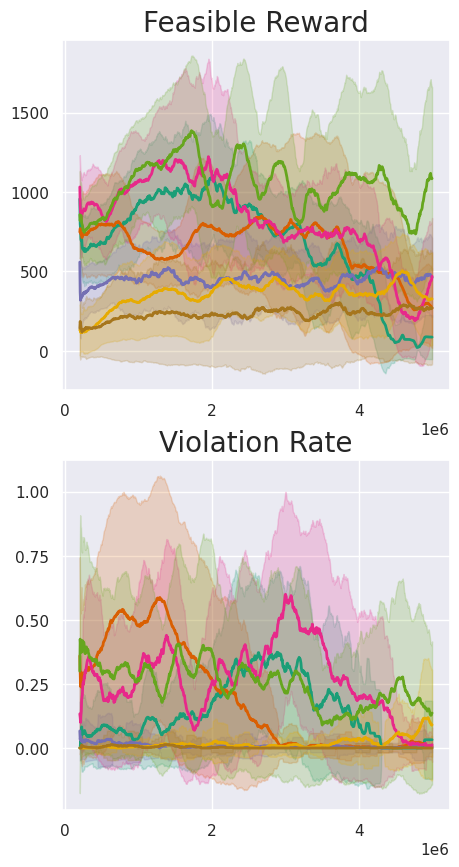

In [37]:
env="walker2d"
fig, axes = plt.subplots(2, 1, figsize=(5, 10))
make_plot(df, axes[0], env=env, group_nsteps=200000, baselines=False, include_legend=False, exps=exps)
make_plot(df, axes[1], env=env, group_nsteps=200000, baselines=False, metric="violation_rate", include_legend=False, exps=exps)
fig.savefig(f"{SAVE_DIR}/{env}.pdf",  bbox_inches=matplotlib.transforms.Bbox(np.array([[-0.5,-0.1], [5, 9.5]])))


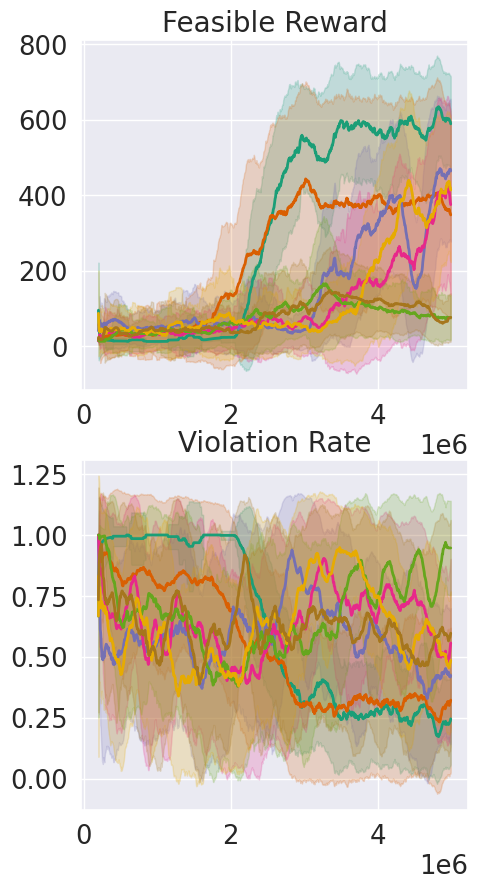

In [38]:
env="swimmer"
fig, axes = plt.subplots(2, 1, figsize=(5, 10))
make_plot(df, axes[0], env=env, group_nsteps=200000, baselines=False, exps=exps)
make_plot(df, axes[1], env=env, group_nsteps=200000, baselines=False, metric="violation_rate", include_legend=False, exps=exps)
plt.savefig(f"{SAVE_DIR}/{env}.pdf",  bbox_inches=matplotlib.transforms.Bbox(np.array([[-0.5,-0.1], [5, 9.5]])))


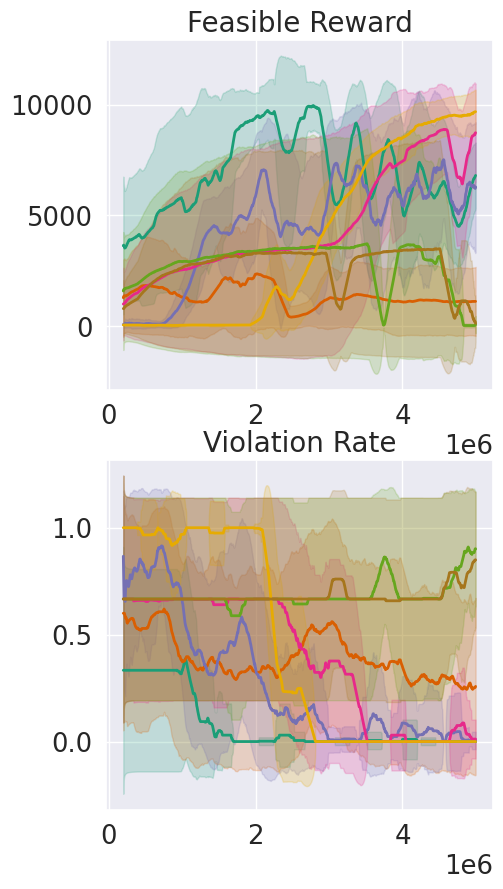

In [39]:
env="half_cheetah"
fig, axes = plt.subplots(2, 1, figsize=(5, 10))
make_plot(df, axes[0], env=env, group_nsteps=200000, baselines=False, exps=exps)
make_plot(df, axes[1], env=env, group_nsteps=200000, baselines=False, metric="violation_rate", exps=exps)
plt.savefig(f"{SAVE_DIR}/{env}.pdf", bbox_inches=matplotlib.transforms.Bbox(np.array([[-0.5,-0.1], [5, 9.5]])))

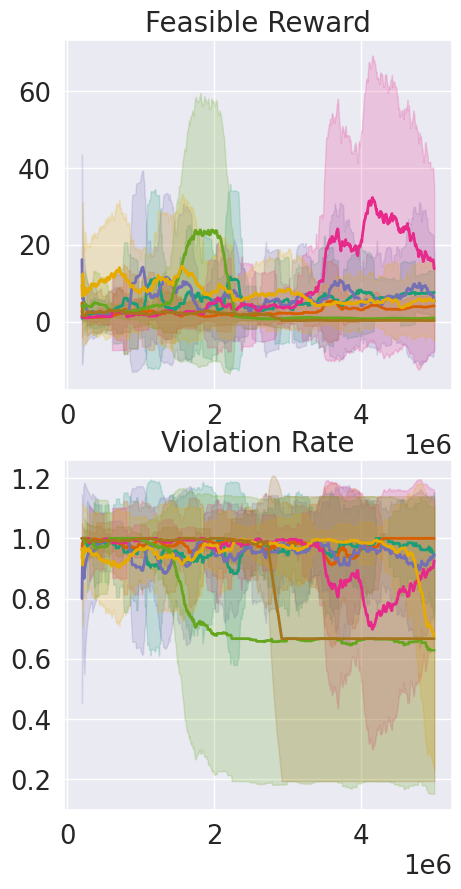

In [40]:
env="inverted_pendulum"
fig, axes = plt.subplots(2, 1, figsize=(5, 10))
make_plot(df, axes[0], env=env, group_nsteps=200000, baselines=False, exps=exps)
make_plot(df, axes[1], env=env, group_nsteps=200000, baselines=False, metric="violation_rate", exps=exps)
# plt.rcParams.update({'figure.autolayout': True})
plt.savefig(f"{SAVE_DIR}/{env}.pdf", bbox_inches=matplotlib.transforms.Bbox(np.array([[-0.5,-0.1], [5, 9.5]]))) 

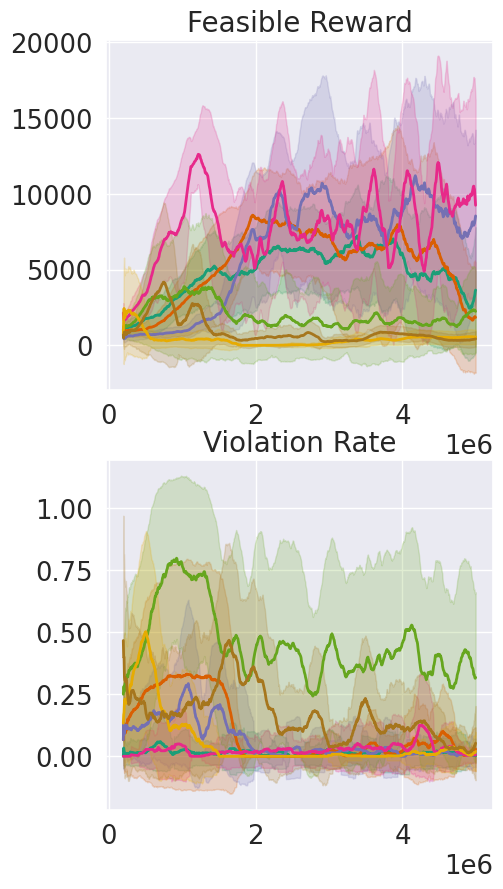

In [41]:
env="ant"
fig, axes = plt.subplots(2, 1, figsize=(5, 10))
make_plot(df, axes[0], env=env, group_nsteps=200000, baselines=False, exps=exps)
make_plot(df, axes[1], env=env, group_nsteps=200000, baselines=False, metric="violation_rate", exps=exps)
plt.savefig(f"{SAVE_DIR}/{env}.pdf", bbox_inches=matplotlib.transforms.Bbox(np.array([[-0.5,-0.1], [5, 9.5]])))

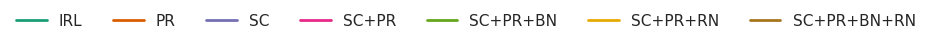

In [42]:
sns.set(font_scale=1)
fig, ax = plt.subplots(1,1, figsize = (11,0.2))
plt.figlegend(*axes[0].get_legend_handles_labels(), loc = 'upper center', ncols=8, frameon=False)
fig.set_frameon(False)
ax.set_frame_on(False)
ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)
plt.savefig(f"{SAVE_DIR}/legend.pdf", bbox_inches='tight')

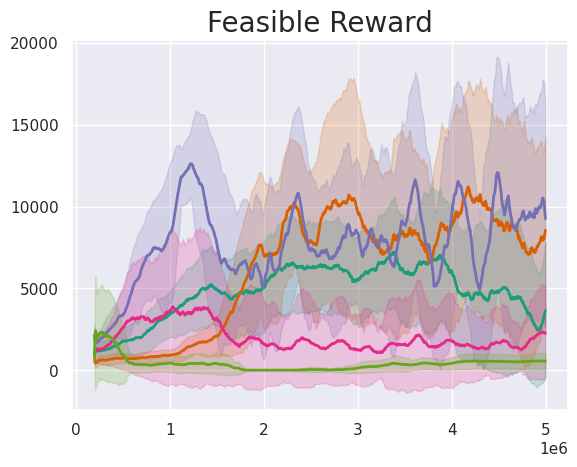

In [43]:
fig, ax = plt.subplots(1,1)
make_plot(df, ax, env=env, group_nsteps=200000, exps=["IRL", "SC", "SC+PR", "SC+PR+BN", "SC+PR+RN"], baselines=False)

hue_order = ax.get_legend_handles_labels()[1]

In [44]:
smoothing=200000

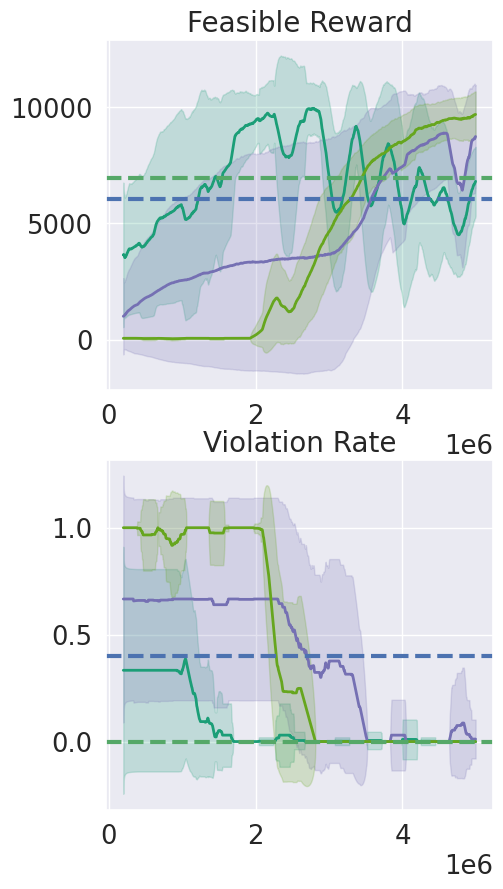

In [45]:
env="half_cheetah"
fig, axes = plt.subplots(2, 1, figsize=(5, 10))
make_plot(df, axes[0], env=env, group_nsteps=smoothing, exps=["IRL", "SC+PR+RN", "SC+PR"], hue_order=hue_order)
make_plot(df, axes[1], env=env, group_nsteps=smoothing, exps=["IRL", "SC+PR+RN", "SC+PR"], metric="violation_rate", hue_order=hue_order)
plt.savefig(f"{SAVE_DIR}/{env}_best.pdf", bbox_inches=matplotlib.transforms.Bbox(np.array([[-0.5,-0.1], [5, 9.5]])))

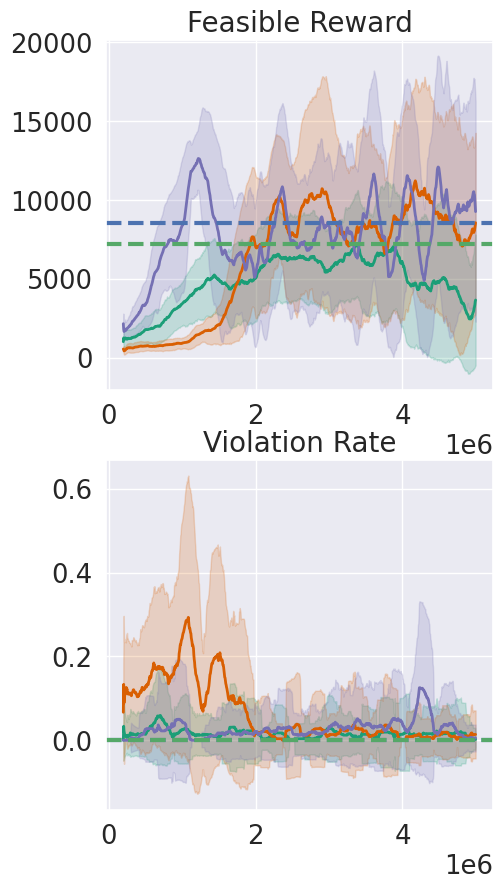

In [50]:
env="ant"
fig, axes = plt.subplots(2, 1, figsize=(5, 10))
make_plot(df, axes[0], env=env, group_nsteps=smoothing, exps=["IRL", "SC", "SC+PR"], hue_order=hue_order)
make_plot(df, axes[1], env=env, group_nsteps=smoothing, exps=["IRL", "SC", "SC+PR"], metric="violation_rate", hue_order=hue_order)
plt.savefig(f"{SAVE_DIR}/{env}_best.pdf", bbox_inches=matplotlib.transforms.Bbox(np.array([[-0.5,-0.1], [5, 9.5]])))

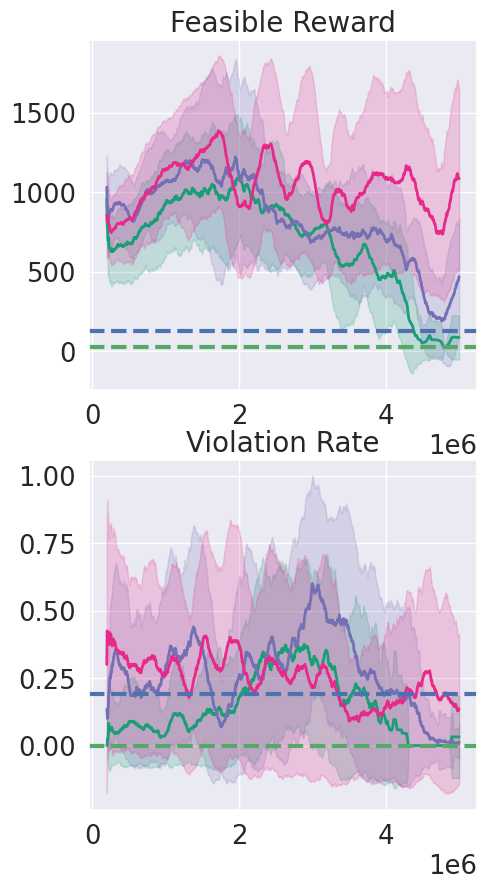

In [51]:
env="walker2d"
fig, axes = plt.subplots(2,1, figsize=(5, 10))
make_plot(df, axes[0], env=env, group_nsteps=smoothing, exps=["IRL", "SC+PR+BN", "SC+PR"], hue_order=hue_order)
make_plot(df, axes[1], env=env, group_nsteps=smoothing, exps=["IRL", "SC+PR+BN", "SC+PR"], metric="violation_rate",hue_order=hue_order)
plt.savefig(f"{SAVE_DIR}/{env}_best.pdf", bbox_inches=matplotlib.transforms.Bbox(np.array([[-0.5,-0.1], [5, 9.5]])))

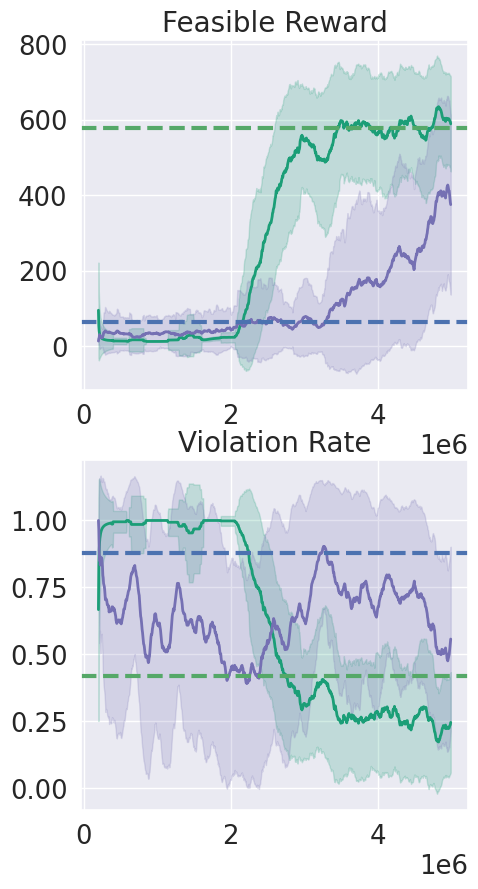

In [52]:
env="swimmer"
fig, axes = plt.subplots(2, 1, figsize=(5, 10))
make_plot(df, axes[0], env=env, group_nsteps=smoothing, exps=["IRL", "SC+PR"], hue_order=hue_order)
make_plot(df, axes[1], env=env, group_nsteps=smoothing, exps=["IRL", "SC+PR"], metric="violation_rate", hue_order=hue_order)
plt.savefig(f"{SAVE_DIR}/{env}_best.pdf", bbox_inches=matplotlib.transforms.Bbox(np.array([[-0.5,-0.1], [5, 9.5]])))

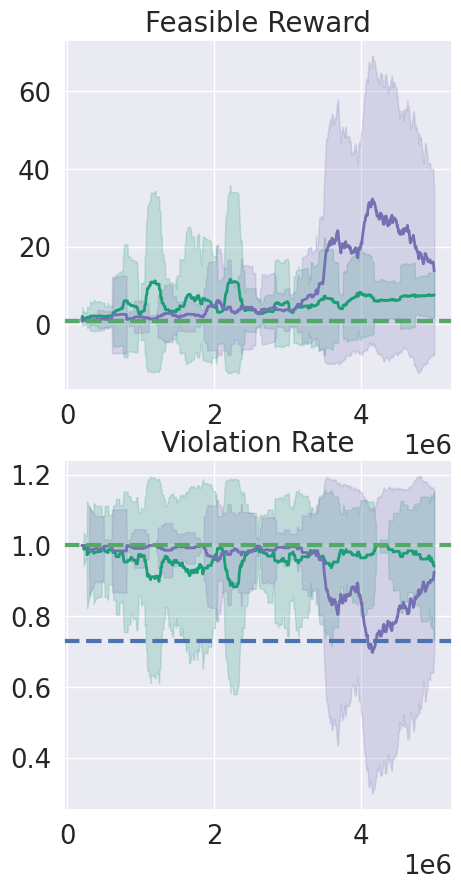

In [54]:
env="inverted_pendulum"
fig, axes = plt.subplots(2, 1, figsize=(5, 10))
make_plot(df, axes[0], env=env, group_nsteps=smoothing, exps=["IRL", "SC+PR"], hue_order=hue_order)
make_plot(df, axes[1], env=env, group_nsteps=smoothing, exps=["IRL", "SC+PR"], metric="violation_rate", hue_order=hue_order)
plt.savefig(f"{SAVE_DIR}/{env}_best.pdf", bbox_inches=matplotlib.transforms.Bbox(np.array([[-0.5,-0.1], [5, 9.5]])))

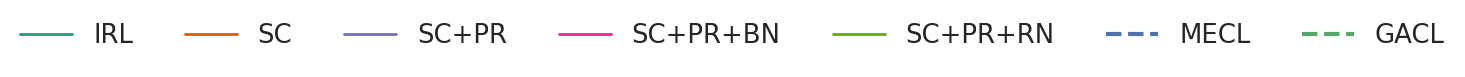

In [55]:
fig, ax = plt.subplots(1,1, figsize = (10,0.2))
plt.figlegend(*axes[0].get_legend_handles_labels(), loc = 'upper center', ncols=10, frameon=False)
fig.set_frameon(False)
ax.set_frame_on(False)
ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)
plt.savefig(f"{SAVE_DIR}/legend_best.pdf", bbox_inches='tight')

### Suboptimal Expert Trajectories

In [56]:
baselines = {"feasible_rewards": {"MECL": {"20%": 3000*2, "50%": 3200*2, "80%": 1600*2}, 
                                  "GACL": {"20%": 0, "50%": 0, "80%": 0}}, 
             "violation_rate": {"MECL": {"20%": 0, "50%": 0, "80%": 0.2}, 
                                  "GACL": {"20%": 0.5, "50%": 0.65, "80%": 0.9}}}

In [57]:
experiment_names = ["sub opt"]
experiments = [api.runs(entity + "/" + project, filters={'tags': exp}) for exp in experiment_names]
runs = [run for runs in experiments for run in runs ]

In [58]:
subopt_df = get_data(runs)
subopt_df['env'] = "half_cheetah"

In [59]:
subopt_df.groupby(['config', 'seed']).count()

_step  feasible_reward  violation_rate   env
config            seed                                              
sub optsub_opt0.2 0      1000             1000            1000  1000
                  1      1000             1000            1000  1000
                  2      1000             1000            1000  1000
sub optsub_opt0.5 0      1000             1000            1000  1000
                  1      1000             1000            1000  1000
                  2      1000             1000            1000  1000
sub optsub_opt0.8 0      1000             1000            1000  1000
                  1      1000             1000            1000  1000
                  2      1000             1000            1000  1000

In [60]:
subopt_df = subopt_df.sort_values("config")

In [61]:
subopt_df.head()

,_step,feasible_reward,violation_rate,config,seed,env
8999,5000000.0,10048.985599,0.0,sub optsub_opt0.2,0,half_cheetah
7004,25000.0,145.879821,1.0,sub optsub_opt0.2,2,half_cheetah
7003,20000.0,179.386052,1.0,sub optsub_opt0.2,2,half_cheetah
7002,15000.0,78.590545,1.0,sub optsub_opt0.2,2,half_cheetah
7001,10000.0,139.813482,1.0,sub optsub_opt0.2,2,half_cheetah


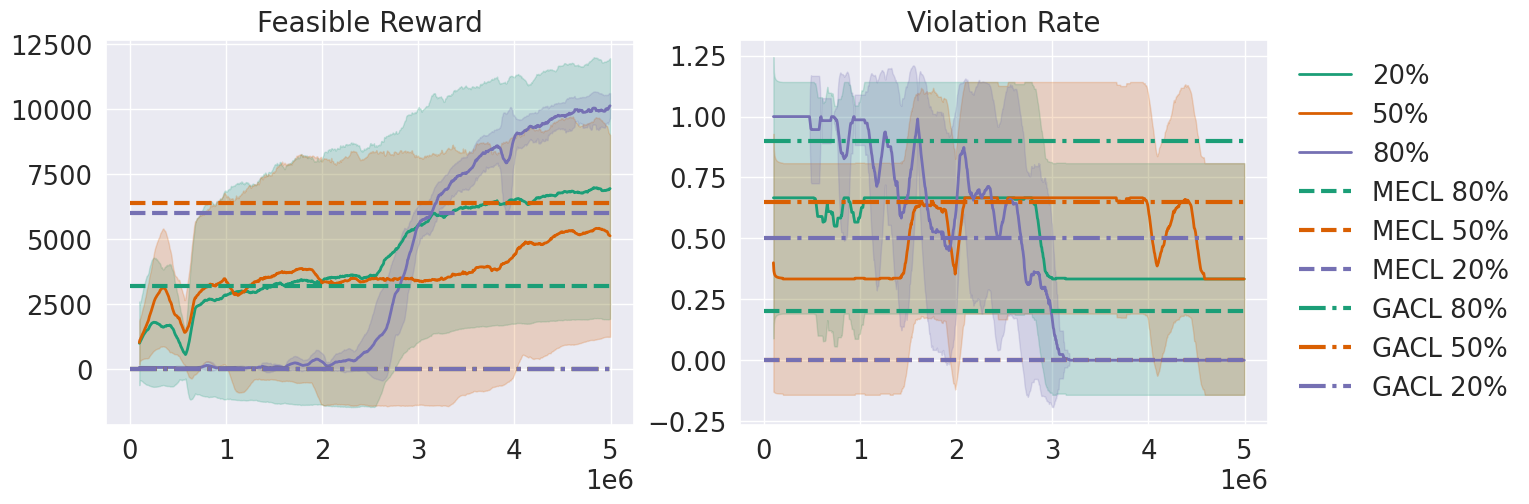

In [62]:
env="half_cheetah"
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
make_plot(subopt_df, axes[0], env=env, group_nsteps=100000, baselines=baselines['feasible_rewards'])
make_plot(subopt_df, axes[1], env=env, group_nsteps=100000,metric="violation_rate",  include_legend=True, baselines=baselines['violation_rate'])
sns.move_legend(axes[1], loc="lower right", bbox_to_anchor=(1.5, 0), ncol=1, title=None, frameon=False)
plt.savefig(f"{SAVE_DIR}/subopt.pdf", bbox_inches='tight')

### Appendix

In [63]:
experiment_names = ["final_baseline", "best_baseline"]
experiments = [api.runs(entity + "/" + project, filters={'tags': exp}) for exp in experiment_names]
runs = [run for runs in experiments for run in runs ]
runs = [(run, '_'.join(re.sub(r"([A-Z])", r"_\1", run.config["task"].split('-')[0]).split('_')[1:-1]).lower()) for run in runs]
runs_by_env = {env: [run[0] for run in runs if run[1]==env] for env in ENVS}

In [64]:
icrl_walker_df = get_data(runs_by_env["walker2d"], add_from_config=["seed", "reward.optim.lr", "policy.lagrangian_optim.lr"])
icrl_walker_df['env'] = 'walker2d'
icrl_swimmer_df = get_data(runs_by_env['swimmer'], add_from_config=["seed", "reward.optim.lr", "policy.lagrangian_optim.lr"])
icrl_swimmer_df['env'] = 'swimmer'
icrl_cheetah_df = get_data(runs_by_env['half_cheetah'], add_from_config=["seed", "reward.optim.lr", "policy.lagrangian_optim.lr"])
icrl_cheetah_df['env'] = 'half_cheetah'
icrl_pendulum_df = get_data(runs_by_env['inverted_pendulum'], add_from_config=["seed", "reward.optim.lr", "policy.lagrangian_optim.lr"])
icrl_pendulum_df['env'] = 'inverted_pendulum'
icrl_ant_df = get_data(runs_by_env['ant'], add_from_config=["seed", "reward.optim.lr", "policy.lagrangian_optim.lr"])
icrl_ant_df['env'] = 'ant'
icrl_df = pd.concat([icrl_walker_df, icrl_swimmer_df, icrl_cheetah_df, icrl_pendulum_df, icrl_ant_df])

In [65]:
icrl_df['config'] = "reward.lr=" + icrl_df['reward.optim.lr'].astype(str) + ", lambda.lr=" + icrl_df['policy.lagrangian_optim.lr'].astype(str)

In [67]:
(icrl_df.groupby(["env", "config", "seed"], as_index=False)._step.max().groupby(["env", "config"])._step.min() > 300000).head(40)

env                config                            
ant                reward.lr=0.0001, lambda.lr=0.0001    True
                   reward.lr=0.0001, lambda.lr=0.001     True
                   reward.lr=0.0001, lambda.lr=0.01      True
                   reward.lr=0.001, lambda.lr=0.0001     True
                   reward.lr=0.001, lambda.lr=0.001      True
                   reward.lr=0.001, lambda.lr=0.01       True
half_cheetah       reward.lr=0.0001, lambda.lr=0.0001    True
                   reward.lr=0.0001, lambda.lr=0.001     True
                   reward.lr=0.0001, lambda.lr=0.01      True
                   reward.lr=0.001, lambda.lr=0.0001     True
                   reward.lr=0.001, lambda.lr=0.001      True
                   reward.lr=0.001, lambda.lr=0.01       True
inverted_pendulum  reward.lr=0.0001, lambda.lr=0.0001    True
                   reward.lr=0.0001, lambda.lr=0.001     True
                   reward.lr=0.0001, lambda.lr=0.01      True
                

In [68]:
hold=icrl_df

In [69]:
icrl_df = icrl_df.loc[icrl_df._step <= 3000000, :]

In [135]:
exps = ["reward.lr=0.0001, lambda.lr=0.01", "reward.lr=0.0001, lambda.lr=0.001"]

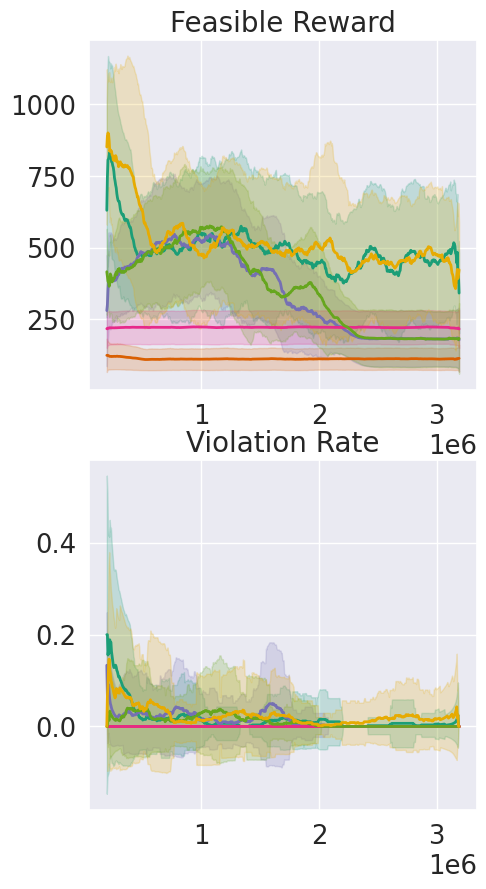

In [71]:
env="walker2d"
fig, axes = plt.subplots(2, 1, figsize=(5, 10))
make_plot(icrl_df, axes[0], env=env, group_nsteps=200000, baselines=False, include_legend=False)#, exps=exps)
make_plot(icrl_df, axes[1], env=env, group_nsteps=200000, baselines=False, metric="violation_rate", include_legend=False)#, exps=exps)
fig.savefig(f"{SAVE_DIR}/{env}_icrl.pdf", bbox_inches=matplotlib.transforms.Bbox(np.array([[-0.5,-0.1], [5, 9.5]])))

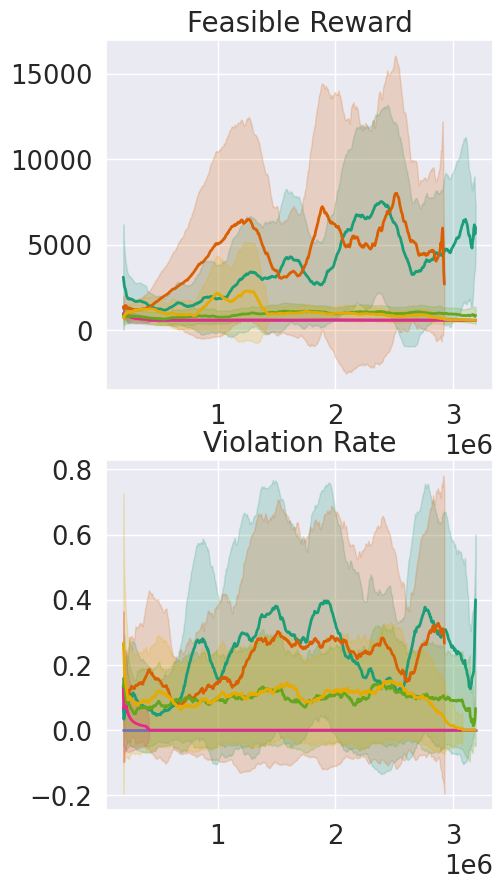

In [72]:
env="ant"
fig, axes = plt.subplots(2, 1, figsize=(5, 10))
make_plot(icrl_df, axes[0], env=env, group_nsteps=200000, baselines=False, include_legend=False)#, exps=exps)
make_plot(icrl_df, axes[1], env=env, group_nsteps=200000, baselines=False, metric="violation_rate", include_legend=False)#, exps=exps)
fig.savefig(f"{SAVE_DIR}/{env}_icrl.pdf", bbox_inches=matplotlib.transforms.Bbox(np.array([[-0.5,-0.1], [5, 9.5]])))

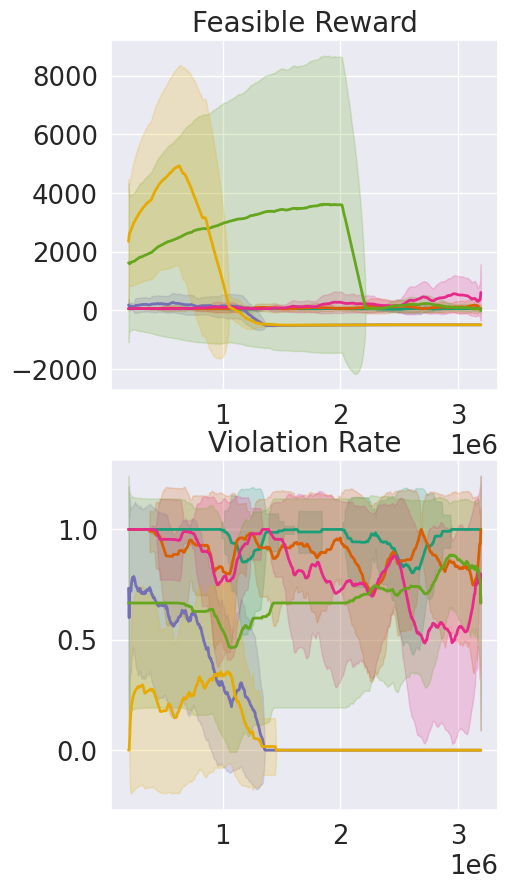

In [74]:
env="half_cheetah"
fig, axes = plt.subplots(2, 1, figsize=(5, 10))
make_plot(icrl_df, axes[0], env=env, group_nsteps=200000, baselines=False, include_legend=False)#, exps=exps)
make_plot(icrl_df, axes[1], env=env, group_nsteps=200000, baselines=False, metric="violation_rate", include_legend=False)#, exps=exps)
fig.savefig(f"{SAVE_DIR}/{env}_icrl.pdf", bbox_inches=matplotlib.transforms.Bbox(np.array([[-0.5,-0.1], [5, 9.5]])))

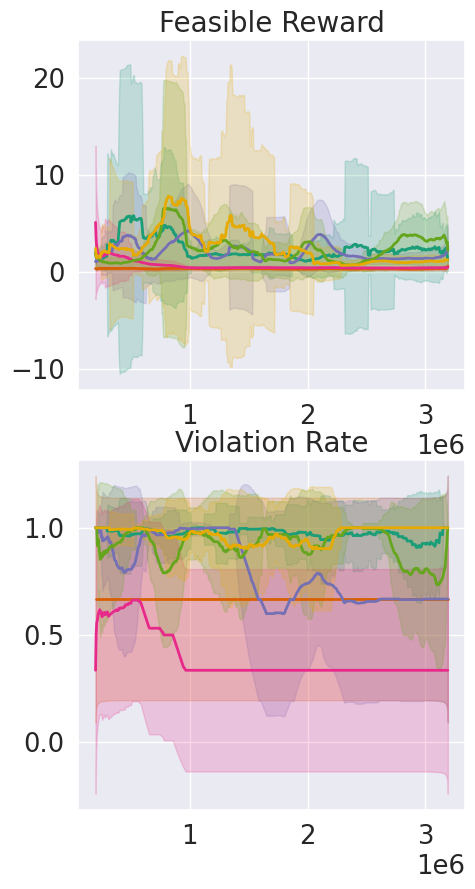

In [75]:
env="inverted_pendulum"
fig, axes = plt.subplots(2, 1, figsize=(5, 10))
make_plot(icrl_df, axes[0], env=env, group_nsteps=200000, baselines=False, include_legend=False)#, exps=exps)
make_plot(icrl_df, axes[1], env=env, group_nsteps=200000, baselines=False, metric="violation_rate", include_legend=False)#, exps=exps)
fig.savefig(f"{SAVE_DIR}/{env}_icrl.pdf", bbox_inches=matplotlib.transforms.Bbox(np.array([[-0.5,-0.1], [5, 9.5]])))

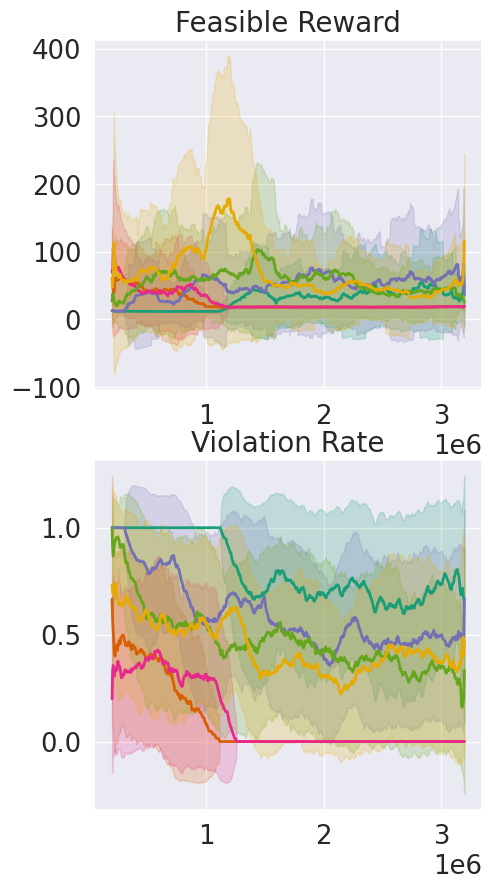

In [76]:
env="swimmer"
fig, axes = plt.subplots(2, 1, figsize=(5, 10))
make_plot(icrl_df, axes[0], env=env, group_nsteps=200000, baselines=False, include_legend=False)#, exps=exps)
make_plot(icrl_df, axes[1], env=env, group_nsteps=200000, baselines=False, metric="violation_rate", include_legend=False)#, exps=exps)
fig.savefig(f"{SAVE_DIR}/{env}_icrl.pdf", bbox_inches=matplotlib.transforms.Bbox(np.array([[-0.5,-0.1], [5, 9.5]])))

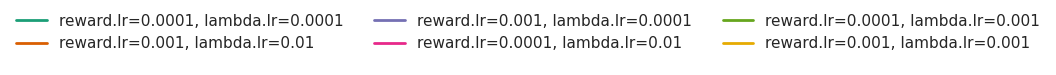

In [79]:
sns.set(font_scale=1)
fig, ax = plt.subplots(1,1, figsize = (11,0.2))
plt.figlegend(*axes[0].get_legend_handles_labels(), loc = 'upper center', ncols=3, frameon=False)
fig.set_frameon(False)
ax.set_frame_on(False)
ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)
plt.savefig(f"{SAVE_DIR}/legend_icrl.pdf", bbox_inches='tight')